# Inverse landscape genetics

Traditional landscape genetics assumes *a priori* which habitat features facilitate or impede movement. Inverse landscape genetics reverses this approach, inferring permeability patterns directly from genetic data. This notebook demonstrates fitting a neural network to predict landscape resistance from land-cover features, optimizing the model to match observed genetic differentiation (Fst) between sampling sites.

We use genetic data from the [Mountain Pygmy-possum](https://en.wikipedia.org/wiki/Mountain_pygmy_possum) (*Burramys parvus*), an endangered marsupial endemic to alpine regions of southeastern Australia, kindly provided by [Cesar Australia](https://cesaraustralia.com). We'll use land-cover data to model landscape permeability and fit the model to observed genetic distances, obtained from ESA WorldCover.
<!-- TODO: update link -->

<div align="center">
  <img src="https://www.australiangeographic.com.au/wp-content/uploads/2018/06/Pygmy-Possum_Amanda-McLean-Copy-1.jpg" width="450">
</div>

### Prerequisites
```bash
pip install jaxscape equinox optimistix rioxarray geopandas scikit-learn
```

 We've prepared the data for you to focus on the modeling aspects; you can download the dataset [here](https://vboussange.github.io/jaxscape/data/inverse_landscape_genetics/). 

In [11]:
import time

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import rioxarray
import xarray as xr
import geopandas as gpd
import equinox as eqx
from equinox import nn
import optimistix as optx

from jaxscape import GridGraph, ResistanceDistance, LCPDistance
from jaxscape.solvers import CholmodSolver
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)

### Configuration parameters

In [12]:
# File paths (adjust to your data location)
LANDCOVER_PATH = '../data/cesar/landcover_7855.tif'
SITE_METADATA_PATH = '../data/cesar/site_metadata.gpkg'
GENETIC_DISTANCES_PATH = '../data/cesar/genetic_dissimilarity.npy'

# Model configuration
COARSENING_FACTOR = 10  # Spatial downsampling of feature raster to accelerate computation
SOLVER = CholmodSolver()  # Fast linear solver for large graphs
DISTANCE_FUN = ResistanceDistance(solver=SOLVER)  # Effective resistance distance
MAX_STEPS = 500  # Maximum optimization iterations

# Alternative distance metric for experimentation:
# DISTANCE_FUN = LCPDistance()  # Least-cost path distance

## Load the data

In [13]:
# Load land-cover raster
predictor_raster = rioxarray.open_rasterio(
    LANDCOVER_PATH, 
    mask_and_scale=True,
)

# Load site metadata (geographic locations)
site_metadata = gpd.read_file(SITE_METADATA_PATH)
site_gdf = site_metadata.to_crs(epsg=7855)  # Reproject to Australian GDA2020

# Load genetic distance matrix
genetic_distances = np.load(GENETIC_DISTANCES_PATH)

print(f"Predictor raster shape: {predictor_raster.shape}")
print(f"Number of sites: {len(site_gdf)}")
print(f"Genetic distance matrix shape: {genetic_distances.shape}")

Predictor raster shape: (1, 4596, 3052)
Number of sites: 12
Genetic distance matrix shape: (12, 12)


## Prepare features and targets

The land-cover raster requires preprocessing before feeding it to the neural network. We first compress the sparse WorldCover class IDs into a contiguous range (0..K-1), then one-hot encode them into binary feature vectors. Spatial coarsening via mean pooling downsamples the raster while preserving land-cover composition within each aggregated cell, capturing habitat heterogeneity without forcing discrete classifications. Finally, we map each sampling site to its nearest grid cell in the coarsened raster. 

In [14]:
def prepare_feature_targets(predictor_raster, site_gdf, coarsening_factor):
    """Process land-cover and create model inputs.
    
    Returns
    -------
    features_onehot_coarse : array
        One-hot encoded land-cover features after coarsening (H, W, K)
    unique_classes : array
        Original WorldCover class values
    target_nodes : array
        Node indices for sampling sites
    grid : GridGraph
        Reference grid for node indexing
    feature_da : xarray.DataArray
        Coarsened feature raster with coordinates
    """
    # Compress WorldCover classes to contiguous IDs
    raw_band = np.asarray(predictor_raster.sel(band=1))
    unique_vals, inverse = np.unique(raw_band.ravel(), return_inverse=True)
    class_ids = inverse.reshape(raw_band.shape).astype(np.int32)
    features_categorical = jnp.array(class_ids).squeeze()
    unique_classes = jnp.array(unique_vals)
    
    print(f"Found {len(unique_vals)} unique land-cover classes")
    
    # One-hot encode: (H, W) -> (H, W, K)
    features_onehot = jax.nn.one_hot(
        features_categorical, 
        num_classes=len(unique_vals)
    )
    
    # Reorder for coarsening: (H, W, K) -> (K, H, W)
    features_onehot = jnp.moveaxis(features_onehot, -1, 0)
    
    # Coarsen using mean pooling (preserves class composition)
    coords = {
        "band": np.arange(features_onehot.shape[0]),
        "y": predictor_raster.y.values,
        "x": predictor_raster.x.values,
    }
    feature_da = xr.DataArray(
        features_onehot,
        coords=coords,
        dims=("band", "y", "x"),
    )
    feature_da = feature_da.coarsen(
        x=coarsening_factor, 
        y=coarsening_factor, 
        boundary="trim"
    ).mean()
    
    # Back to (H, W, K)
    features_onehot_coarse = jnp.moveaxis(feature_da.data, 0, -1)
    print(f"Coarsened feature shape: {features_onehot_coarse.shape}")
    
    # Map site coordinates to coarsened grid indices
    x_idx = jnp.array([
        int(np.argmin(np.abs(feature_da.x.values - x))) 
        for x in site_gdf.geometry.x.values
    ])
    y_idx = jnp.array([
        int(np.argmin(np.abs(feature_da.y.values - y))) 
        for y in site_gdf.geometry.y.values
    ])
    
    # Create reference grid for node indexing
    grid = GridGraph(
        jnp.ones((feature_da.x.size, feature_da.y.size)), 
        fun=lambda x, y: (x + y) / 2
    )
    target_nodes = grid.coord_to_index(x_idx, y_idx)
    
    return features_onehot_coarse, unique_classes, target_nodes, grid, feature_da

# Process features
features_onehot, unique_classes, target_nodes, ref_grid, coarse_feature_da = prepare_feature_targets(
    predictor_raster, site_gdf, COARSENING_FACTOR
)

print(f"Target nodes (site indices): {target_nodes}")

Found 8 unique land-cover classes
Coarsened feature shape: (459, 305, 8)
Target nodes (site indices): [112719  65962  29307  27474  35742 109760  36622  37079  76894  63615
  35723  91477]


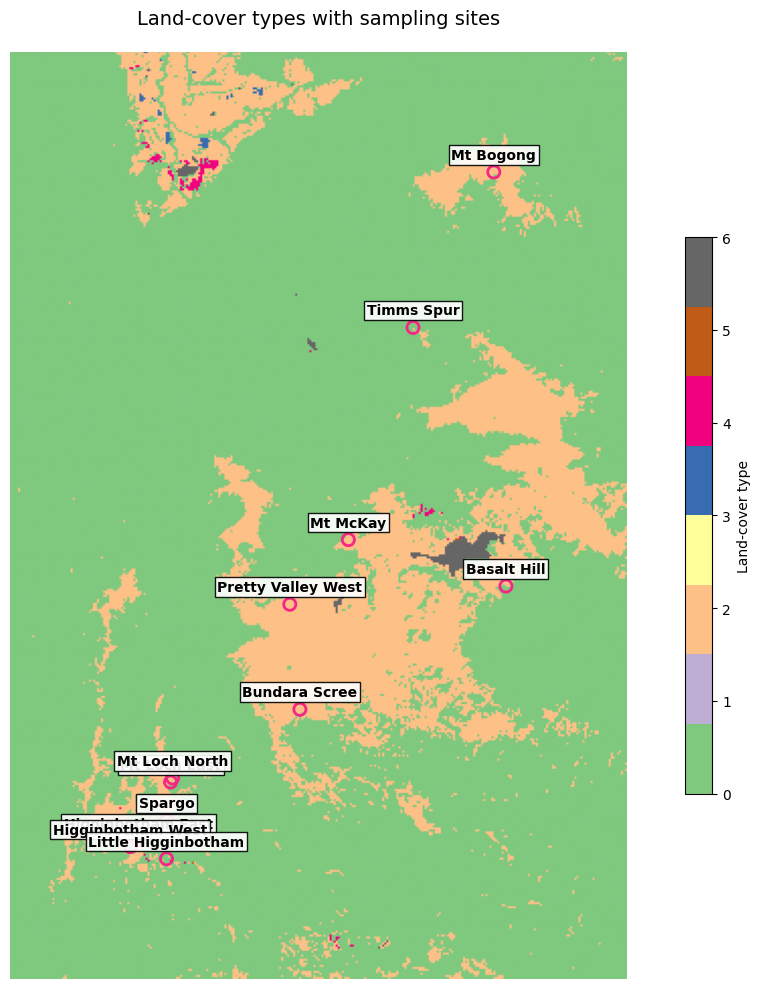

In [15]:
from matplotlib.patches import Circle

# Visualize coarsened land-cover with sites
node_coords = ref_grid.index_to_coord(target_nodes)
x_indices, y_indices = node_coords[:, 0], node_coords[:, 1]

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(features_onehot.argmax(axis=-1), cmap="Accent")

# Add colorbar for land-cover types
plt.colorbar(im, ax=ax, label="Land-cover type", shrink=0.6)

# Annotate sites
for xi, yi, name in zip(x_indices, y_indices, site_gdf["site_name"].values):
    circle = Circle(
        (int(xi), int(yi)),
        radius=3,
        fill=False, 
        edgecolor='#f72585', 
        linewidth=2,
    )
    ax.add_patch(circle)

    ax.text(
        int(xi), int(yi) - 5,
        str(name),
        color="black",
        fontsize=10,
        fontweight='bold',
        ha="center",
        va="bottom",
        bbox=dict(facecolor="white", alpha=0.9, edgecolor="black", pad=2),
    )

ax.set_title("Land-cover types with sampling sites", fontsize=14, pad=20)
ax.axis('off')
plt.tight_layout()
plt.show()

## Define the permeability model

We build a neural network mapping one-hot land-cover features to positive permeability values: $\text{permeability} = \exp(\text{NN}(\text{features})) + \epsilon$. The architecture takes a K-dimensional one-hot vector (land-cover classes), passes it through two hidden layers with ReLU activation (16 units each), and outputs a single value that is exponentiated to ensure positivity. We apply this model pixel-wise via `vmap` to generate the full permeability surface.

In [16]:
def build_model(num_classes: int, seed: int = 2) -> tuple:
    """Build neural permeability model.
    
    Parameters
    ----------
    num_classes : int
        Number of land-cover classes
    seed : int
        Random seed for initialization
        
    Returns
    -------
    model : eqx.Module
        Complete model
    params : pytree
        Trainable parameters
    static : pytree
        Static (non-trainable) components
    """
    key = jax.random.PRNGKey(seed)
    
    class PermeabilityModel(eqx.Module):
        layers: list
        num_classes: int
        
        def __init__(self, num_classes: int, key):
            self.num_classes = num_classes
            k1, k2, k3 = jax.random.split(key, 3)
            hidden_dim = 16
            
            self.layers = [
                nn.Linear(num_classes, hidden_dim, key=k1),
                jax.nn.relu,
                nn.Linear(hidden_dim, hidden_dim, key=k2),
                jax.nn.relu,
                nn.Linear(hidden_dim, 1, key=k3),
            ]
        
        def __call__(self, x):
            """Map one-hot feature to positive permeability."""
            for layer in self.layers:
                x = layer(x)
            return jnp.minimum(jnp.exp(x) + 1e-1, 1e3)  # Ensure positive permeability, keep within reasonable bounds
    
    model = PermeabilityModel(num_classes, key)
    params, static = eqx.partition(model, eqx.is_inexact_array)
    return model, params, static

# Initialize model
model, params, static = build_model(len(unique_classes))
print(f"Model initialized with {len(unique_classes)} land-cover classes")
print(f"Trainable parameters: {sum(p.size for p in jax.tree_util.tree_leaves(params))}")

Model initialized with 8 land-cover classes
Trainable parameters: 433


Before training, the model produces random permeability values based on the initialization.

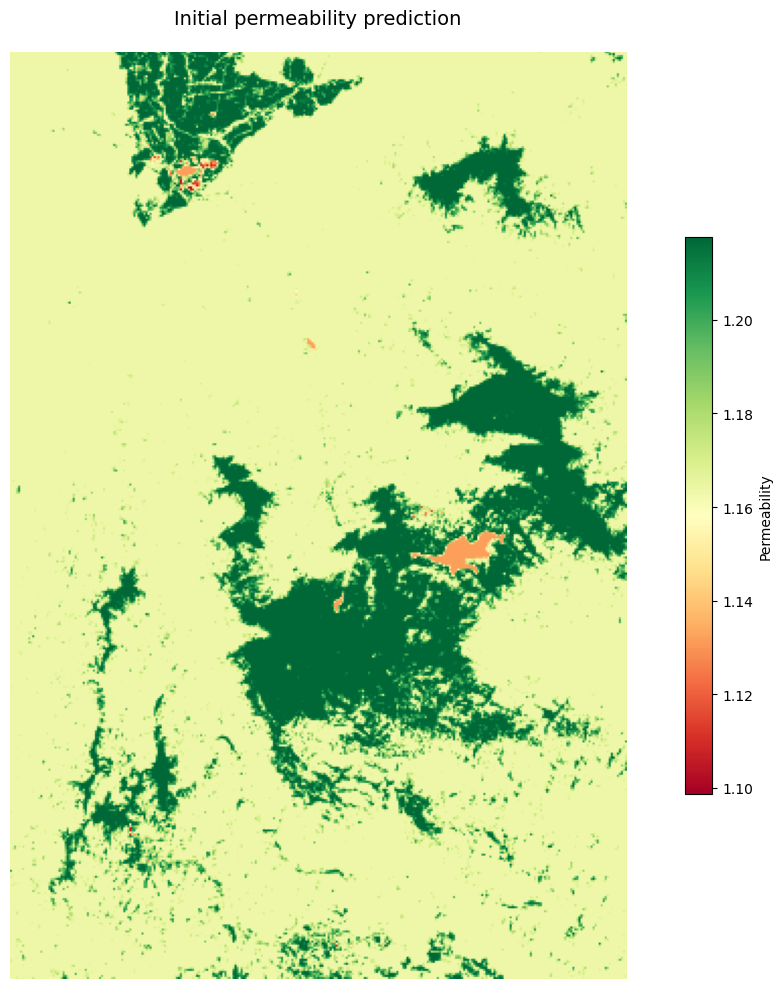

In [17]:
# Apply model to all pixels via vmap
model_vmapped = jax.vmap(jax.vmap(model, in_axes=0), in_axes=0)
initial_permeability = model_vmapped(features_onehot).squeeze()

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(initial_permeability, cmap="RdYlGn")
ax.set_title("Initial permeability prediction", fontsize=14, pad=20)
ax.axis("off")
plt.colorbar(im, ax=ax, label="Permeability", shrink=0.6)
plt.tight_layout()
plt.show()

## Define loss function and training setup

We minimize mean squared error (MSE) between predicted resistance distances and observed genetic distances. The training loop predicts pixel-wise permeability, constructs a GridGraph, computes pairwise resistance distances between sampling sites, and backpropagates gradients through the entire pipeline using L-BFGS optimization.

We split pairwise distances (upper triangle of the matrix) into 80% training and 20% test sets to evaluate generalization. This train/test split reveals whether the model learns meaningful permeability patterns or simply memorizes training data.

In [18]:
@eqx.filter_jit
def loss_fn(params, args):
    static, features, target_flat_train, tri_i_train, tri_j_train = args
    
    # Reconstruct model and predict permeability surface
    model = eqx.combine(params, static)
    model_vmapped = jax.vmap(jax.vmap(model, in_axes=0), in_axes=0)
    permeability = model_vmapped(features).squeeze()
    
    # Build graph and compute permeability distances
    grid = GridGraph(permeability, fun=lambda x, y: (x + y) / 2)
    predicted_distances = DISTANCE_FUN(grid, nodes=target_nodes)
    
    # Extract training pairs and compute loss
    pred_flat_train = predicted_distances[tri_i_train, tri_j_train]
    return ((target_flat_train - pred_flat_train) ** 2).mean()

In [ ]:
# Extract upper triangle indices (all unique pairs)
n_sites = genetic_distances.shape[0]
tri_i_all, tri_j_all = np.triu_indices(n_sites, k=1)
target_flat_all = np.asarray(genetic_distances)[tri_i_all, tri_j_all]

print(f"Total pairwise distances: {len(target_flat_all)}")

# Train/test split (80/20)
(
    target_flat_train,
    target_flat_test,
    tri_i_train,
    tri_i_test,
    tri_j_train,
    tri_j_test,
) = train_test_split(
    target_flat_all,
    tri_i_all,
    tri_j_all,
    test_size=0.2,
    random_state=2,
)

# Convert to JAX arrays for training
tri_i_train = jnp.array(tri_i_train)
tri_j_train = jnp.array(tri_j_train)
tri_i_test = np.array(tri_i_test)
tri_j_test = np.array(tri_j_test)

print(f"Training pairs: {len(target_flat_train)}")
print(f"Test pairs: {len(target_flat_test)}")

# Sanity check: compute initial loss
initial_loss = loss_fn(
    params, 
    (static, features_onehot, target_flat_train, tri_i_train, tri_j_train)
)
print(f"\nInitial training loss: {initial_loss:.6f}")

Total pairwise distances: 66
Training pairs: 52
Test pairs: 14

Initial training loss: 3.805207


## Training
The optimization typically takes several minutes depending on graph size and the number of iterations required for convergence.

In [20]:
# Configure L-BFGS optimizer
solver = optx.LBFGS(
    rtol=1e-5,  # Relative tolerance for convergence
    atol=1e-5,  # Absolute tolerance
    verbose=frozenset({"loss"})  # Print loss during optimization
)

print("Starting optimization...\n")
print("="*60)

start_train_time = time.time()

# Run optimization
opt_solution = optx.minimise(
    loss_fn,
    solver,
    params,
    args=(static, features_onehot, target_flat_train, tri_i_train, tri_j_train),
    max_steps=MAX_STEPS,
)

training_time = time.time() - start_train_time

print("="*60)
print(f"\n✓ Training completed in {training_time:.2f} seconds")
print(f"\nOptimization statistics:")
print(opt_solution.stats)

Starting optimization...

Loss on this step: 3.8052117824554443, Loss on the last accepted step: 0.0
Loss on this step: 0.00981890968978405, Loss on the last accepted step: 3.8052117824554443
Loss on this step: 0.009818751364946365, Loss on the last accepted step: 3.8052117824554443
Loss on this step: 0.0022555768955498934, Loss on the last accepted step: 3.8052117824554443
Loss on this step: 0.002252308651804924, Loss on the last accepted step: 0.0022555768955498934
Loss on this step: 0.0022489570546895266, Loss on the last accepted step: 0.002252308651804924
Loss on this step: 0.0022460371255874634, Loss on the last accepted step: 0.0022489570546895266
Loss on this step: 0.002243201481178403, Loss on the last accepted step: 0.0022460371255874634
Loss on this step: 0.0022407518699765205, Loss on the last accepted step: 0.002243201481178403
Loss on this step: 0.002238163724541664, Loss on the last accepted step: 0.0022407518699765205
Loss on this step: 0.002235413994640112, Loss on the

### Visualize the learned permeability surface


In [21]:
# Apply fitted model to landscape
fitted_model = eqx.combine(opt_solution.value, static)
fitted_vmapped = jax.vmap(jax.vmap(fitted_model, in_axes=0), in_axes=0)
fitted_permeability = fitted_vmapped(features_onehot).squeeze()

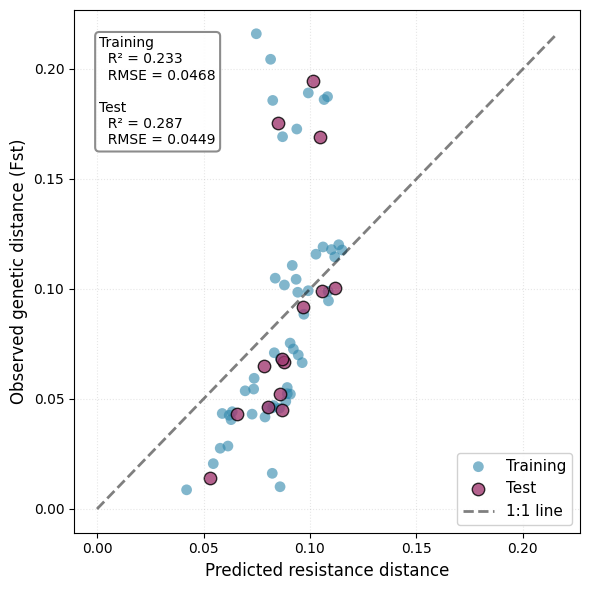

In [22]:
# Compute predicted distances using fitted permeability
pred_grid = GridGraph(fitted_permeability, fun=lambda x, y: (x + y) / 2)
pred_distances = DISTANCE_FUN(pred_grid, nodes=target_nodes)

genetic_np = np.asarray(genetic_distances)
pred_np = np.asarray(pred_distances)

# Extract predictions for train and test pairs
train_pred = pred_np[tri_i_train, tri_j_train]
test_pred = pred_np[tri_i_test, tri_j_test]
train_target = target_flat_train
test_target = target_flat_test

# Compute metrics
r2_train = r2_score(train_target, train_pred)
r2_test = r2_score(test_target, test_pred)
rmse_train = np.sqrt(mean_squared_error(train_target, train_pred))
rmse_test = np.sqrt(mean_squared_error(test_target, test_pred))

fig, ax = plt.subplots(figsize=(6, 6))

# Plot training and test predictions
ax.scatter(
    train_pred, train_target, 
    s=60, alpha=0.6, 
    edgecolor="none", 
    label="Training",
    c='#2E86AB'
)
ax.scatter(
    test_pred, test_target, 
    s=80, alpha=0.8, 
    edgecolor="black",
    linewidth=1,
    label="Test",
    c='#A23B72'
)

# 1:1 reference line
min_val = min(pred_np.min(), genetic_np.min())
max_val = max(pred_np.max(), genetic_np.max())
ax.plot(
    [min_val, max_val], [min_val, max_val], 
    "k--", linewidth=2, 
    alpha=0.5,
    label="1:1 line"
)

ax.set_xlabel("Predicted resistance distance", fontsize=12)
ax.set_ylabel("Observed genetic distance (Fst)", fontsize=12)

# Add metrics box
textstr = (
    f"Training\n"
    f"  R² = {r2_train:.3f}\n"
    f"  RMSE = {rmse_train:.4f}\n\n"
    f"Test\n"
    f"  R² = {r2_test:.3f}\n"
    f"  RMSE = {rmse_test:.4f}"
)
ax.text(
    0.05, 0.95,
    textstr,
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=dict(
        boxstyle="round", 
        facecolor="white", 
        alpha=0.9, 
        edgecolor="gray",
        linewidth=1.5
    ),
)

ax.legend(loc="lower right", fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle=':')
plt.tight_layout()
plt.show()

Our model seems to perform reasonably well, capturing a significant portion of the variance in genetic distances. 
We can now visualize the learned permeability patterns across the landscape. Remember that this is to be interpreted with great caution, as the inferred permeability surface may reflect complex interactions and correlations in the data rather than direct causal relationships.

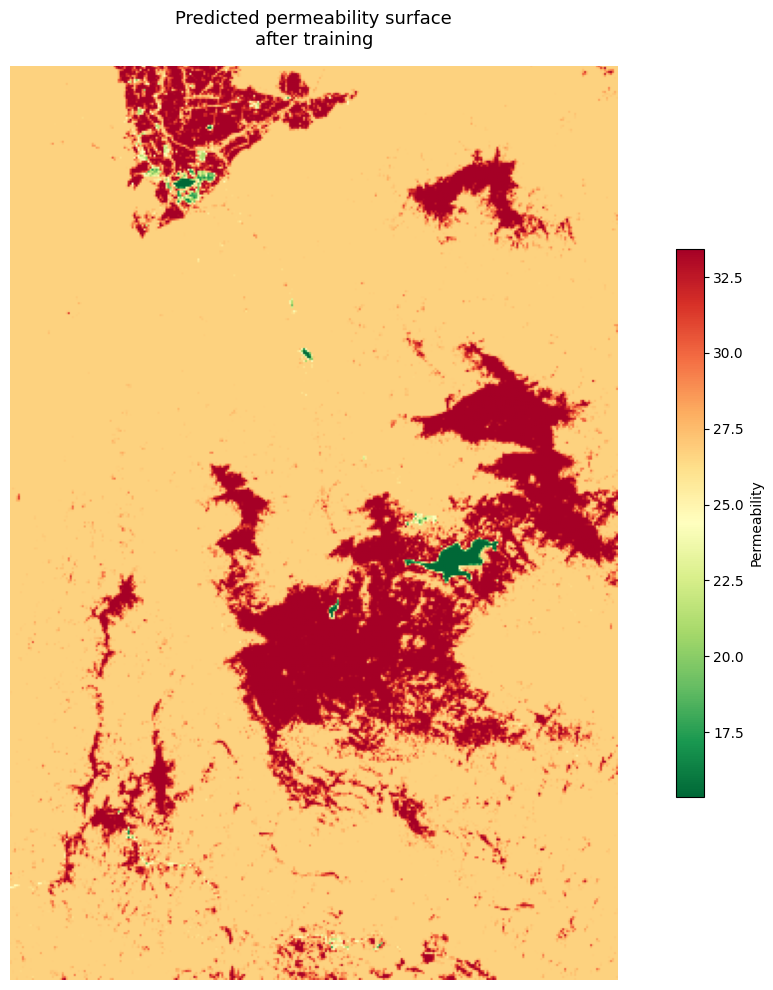

In [23]:
fig, ax = plt.subplots(figsize=(12, 10))

# Fitted permeability
im = ax.imshow(fitted_permeability, cmap="RdYlGn_r")
ax.set_title("Predicted permeability surface\nafter training", fontsize=13, pad=15)
ax.axis("off")
plt.colorbar(im, ax=ax, shrink=0.6, label="Permeability")

plt.tight_layout()
plt.show()

The red surface corresponds to mountain ranges, separating the different populations. To go further, we could use more informative features, such as elevation, climate, etc...

## Key takeaways

This notebook demonstrated inverse landscape genetics: learning resistance patterns from genetic data rather than assuming them *a priori*. JAX's automatic differentiation enables gradient-based optimization, allowing to train neural networks to map landscape features to a permeability surface. Neural networks provide flexible parameterization capturing nonlinear landscape feature–permeability relationships. It would be interesting to compare this learned resistance surface with expert knowledge about the species' ecology and known barriers to movement in the landscape. We could also assess the predictive performance of e.g. the `LCPDistance`. But this goes beyond the scope of this notebook.